# 1. Packages installation & Imports

In [1]:
from platform import python_version
python_version()

'3.9.12'

## 1.1 Packages installation (minimum nb with greater dependencies first, then other ones)

In [2]:
# pip install pandas tensorflow pyspark Pillow pyarrow

## 1.2 Packages import

In [3]:
# data analysis and calculation with matrixes and figures
import pandas as pd
import numpy as np

# basic image processing functionalities
from PIL import Image

# I/O data flow management
import io

# actions on operating system
import os

# échange de données au format Java Script Object Notation
import json

# 3 = INFO and WARNING messages are not printed (see details below)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Tensorflow package with VGG16 model
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

# PySpark
from pyspark.sql.functions import col, pandas_udf, PandasUDFType
from pyspark.sql import SparkSession
from pyspark import SparkConf

Usage of `os.environ` parameter :<br>
-  os.environ["TF_CPP_MIN_LOG_LEVEL"]='1'     # Default level of logs to be displayed. All information is displayed.
-  os.environ["TF_CPP_MIN_LOG_LEVEL"]='2'     # Only warning and error information is displayed.
-  os.environ["TF_CPP_MIN_LOG_LEVEL"]='3'     # Only error information is displayed.

# 2. Connexion to AWS S3 & Spark session set up

## 2.1 AWS credentials retrieval 

PySpark contains a primary object, the SparkSession, used to launch Spark jobs.<br>
It need to be feeded with configuration data to start a PySpark session.<br>
First we need to obtain the necessary credentials so PySpark can access to AWS :

In [4]:
# identifiants nécessaires pour que PySpark accède à AWS
AWS_CREDENTIALS = json.loads(os.popen("aws sts get-session-token").read())['Credentials']

## 2.2 Spark Session set up

Because Spark was coded in Scala (Java based), need to feed the Spark Session with java packages
In addition, we need hadoop and s3 credential management tools with a temporary access

S3A enables Hadoop to directly read and write Amazon S3 objects.

**fs.s3a.aws.credentials.provider** :
Comma-separated class names of credential provider classes which implement
    com.amazonaws.auth.AWSCredentialsProvider

**fs.s3a.secret.key** :
Omit for IAM role-based or provider-based authentication.

**fs.s3a.access.key** :
Omit for IAM role-based or provider-based authentication.

**fs.s3a.TemporaryAWSCredentialsProvider** :
These are the session credentials.<br>
Temporary Security Credentials can be obtained from the Amazon Security Token Service<br>
These consist of an access key, a secret key, and a session token.<br>
The lifetime of session credentials are fixed when the credentials are issued<br>
Once they expire the application will no longer be able to authenticate to AWS.<br>

3 informations are mandatory for a proper AWS identification :
- Access Key ID
- Secret Access Key
- Session Token

They will also be passed to the spark session via the SparkConf().set command.

In [5]:
# defining the Spark configuration object
conf = SparkConf()

# Necessary ressources SparkConf to run PySPark on AWS
# PySPark was coded in Scala itself coded in Java
# To run on AWS, we need to install AWS packages
# For the access we ask for AWS Credential
conf.set('spark.jars.packages', 'org.apache.hadoop:hadoop-aws:3.2.2')
conf.set('spark.hadoop.fs.s3a.aws.credentials.provider', 'org.apache.hadoop.fs.s3a.TemporaryAWSCredentialsProvider')

# Credentials passed to the SparkConf to get  access to S3 Bucket
conf.set('spark.hadoop.fs.s3a.access.key', AWS_CREDENTIALS['AccessKeyId'])
conf.set('spark.hadoop.fs.s3a.secret.key', AWS_CREDENTIALS['SecretAccessKey'])
conf.set('spark.hadoop.fs.s3a.session.token', AWS_CREDENTIALS['SessionToken'])

# SparkSession creation, to launch Spark jobs
spark = SparkSession.builder.config(conf=conf).getOrCreate()

22/11/17 08:01:21 WARN Utils: Your hostname, ip-172-31-36-181 resolves to a loopback address: 127.0.1.1; using 172.31.36.181 instead (on interface eth0)
22/11/17 08:01:21 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
:: loading settings :: url = jar:file:/home/admin/miniconda3/lib/python3.9/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/admin/.ivy2/cache
The jars for the packages stored in: /home/admin/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-afed2f0f-71ac-4b69-a0f5-e12237f0fef7;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.2.2 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.563 in central
:: resolution report :: resolve 432ms :: artifacts dl 19ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.563 from central in [default]
	org.apache.hadoop#hadoop-aws;3.2.2 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	---------------------------------

22/11/17 08:01:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


# 3. Load data : images groups retrieval from S3

As we are performing a proof of concept, we do not need to select all the images.<br>
We will select a few hundreds of pictures, from 3 families of fruits, that will be enough to test the architecture

We will test the 3 datasets Test / Training / Validation, and for each one we will test 3 fruits / vegetables families : apples, carrot, pears

In [6]:
# creation of dataframe for Test files (apple_6)
# filtre sur l'extension, lecture récursive des fichiers, localisation du bucket
images1 = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load("s3a://s3-ds-p8/Test/apple_6/*")

22/11/17 08:01:30 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


In [7]:
images1.show()

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|s3a://s3-ds-p8/Te...|2022-11-15 16:36:58| 21597|[FF D8 FF E0 00 1...|
|s3a://s3-ds-p8/Te...|2022-11-15 16:36:58| 21525|[FF D8 FF E0 00 1...|
|s3a://s3-ds-p8/Te...|2022-11-15 16:36:58| 21382|[FF D8 FF E0 00 1...|
|s3a://s3-ds-p8/Te...|2022-11-15 16:36:58| 21381|[FF D8 FF E0 00 1...|
|s3a://s3-ds-p8/Te...|2022-11-15 16:36:58| 21371|[FF D8 FF E0 00 1...|
|s3a://s3-ds-p8/Te...|2022-11-15 16:36:58| 21274|[FF D8 FF E0 00 1...|
|s3a://s3-ds-p8/Te...|2022-11-15 16:36:58| 21250|[FF D8 FF E0 00 1...|
|s3a://s3-ds-p8/Te...|2022-11-15 16:36:58| 21247|[FF D8 FF E0 00 1...|
|s3a://s3-ds-p8/Te...|2022-11-15 16:36:57| 21139|[FF D8 FF E0 00 1...|
|s3a://s3-ds-p8/Te...|2022-11-15 16:36:57| 21113|[FF D8 FF E0 00 1...|
|s3a://s3-ds-p8/Te...|2022-11-15 16:36:58| 20966|[FF D8 FF E0 00 1...|
|s3a:/

In [8]:
# creation of dataframe for Training files (carrot_1)
# filtre sur l'extension, lecture récursive des fichiers, localisation du bucket
images2 = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load("s3a://s3-ds-p8/Training/carrot_1/*")

In [9]:
images2.show()

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|s3a://s3-ds-p8/Tr...|2022-11-15 16:42:28| 32672|[FF D8 FF E0 00 1...|
|s3a://s3-ds-p8/Tr...|2022-11-15 16:42:28| 32566|[FF D8 FF E0 00 1...|
|s3a://s3-ds-p8/Tr...|2022-11-15 16:42:26| 32544|[FF D8 FF E0 00 1...|
|s3a://s3-ds-p8/Tr...|2022-11-15 16:42:26| 32393|[FF D8 FF E0 00 1...|
|s3a://s3-ds-p8/Tr...|2022-11-15 16:42:26| 32362|[FF D8 FF E0 00 1...|
|s3a://s3-ds-p8/Tr...|2022-11-15 16:42:28| 32310|[FF D8 FF E0 00 1...|
|s3a://s3-ds-p8/Tr...|2022-11-15 16:42:27| 32303|[FF D8 FF E0 00 1...|
|s3a://s3-ds-p8/Tr...|2022-11-15 16:42:29| 32295|[FF D8 FF E0 00 1...|
|s3a://s3-ds-p8/Tr...|2022-11-15 16:42:26| 32232|[FF D8 FF E0 00 1...|
|s3a://s3-ds-p8/Tr...|2022-11-15 16:42:26| 32226|[FF D8 FF E0 00 1...|
|s3a://s3-ds-p8/Tr...|2022-11-15 16:42:26| 32142|[FF D8 FF E0 00 1...|
|s3a:/

In [10]:
# creation of dataframe for Validation files (pear_1)
# filtre sur l'extension, lecture récursive des fichiers, localisation du bucket
images3 = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load("s3a://s3-ds-p8/Validation/pear_1/*")

In [11]:
images3.show()

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|s3a://s3-ds-p8/Va...|2022-11-15 16:45:17| 57379|[FF D8 FF E0 00 1...|
|s3a://s3-ds-p8/Va...|2022-11-15 16:45:17| 56927|[FF D8 FF E0 00 1...|
|s3a://s3-ds-p8/Va...|2022-11-15 16:45:17| 56817|[FF D8 FF E0 00 1...|
|s3a://s3-ds-p8/Va...|2022-11-15 16:45:17| 56624|[FF D8 FF E0 00 1...|
|s3a://s3-ds-p8/Va...|2022-11-15 16:45:17| 56153|[FF D8 FF E0 00 1...|
|s3a://s3-ds-p8/Va...|2022-11-15 16:45:17| 56137|[FF D8 FF E0 00 1...|
|s3a://s3-ds-p8/Va...|2022-11-15 16:45:17| 56067|[FF D8 FF E0 00 1...|
|s3a://s3-ds-p8/Va...|2022-11-15 16:45:17| 55936|[FF D8 FF E0 00 1...|
|s3a://s3-ds-p8/Va...|2022-11-15 16:45:17| 55928|[FF D8 FF E0 00 1...|
|s3a://s3-ds-p8/Va...|2022-11-15 16:45:11| 55906|[FF D8 FF E0 00 1...|
|s3a://s3-ds-p8/Va...|2022-11-15 16:45:13| 55803|[FF D8 FF E0 00 1...|
|s3a:/

**Image visualization test**

-  Apple :

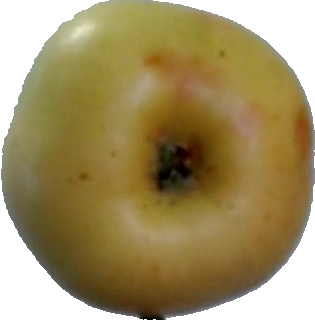

In [12]:
img = images1.select(col("content")).first()[0]
img = Image.open(io.BytesIO(img))
img

-  Carrot :

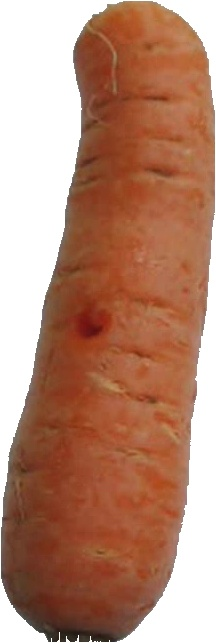

In [13]:
img = images2.select(col("content")).first()[0]
img = Image.open(io.BytesIO(img))
img

-  Pear :

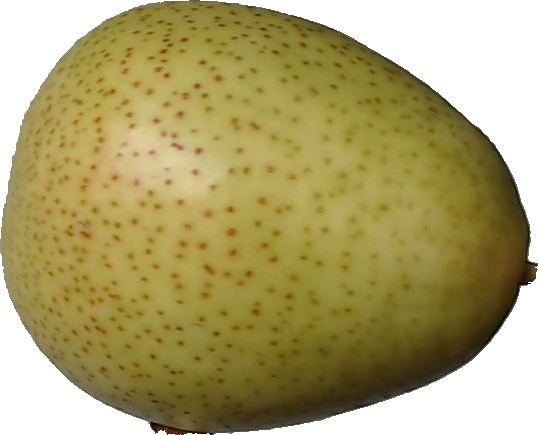

In [14]:
img = images3.select(col("content")).first()[0]
img = Image.open(io.BytesIO(img))
img

# 4. Model preparation

**Prepare the model**

I prepare a model file for dimension reduction / featurization, and truncate the last layer(s).<br>
This notebook uses VGG16.

Spark workers need to access the model and its weights.

For moderately sized models (< 1GB in size), a good practice is to download the model to the Spark driver and then broadcast the weights to the workers.

For large models (> 1GB), it is best to load the model weights from distributed storage to workers directly.<br>
This notebook uses this approach.

In [15]:
# Change input shape dimensions for fine-tuning with Keras
# remove last layer (include_top=False) to get a Tensor
model = VGG16(weights="imagenet", include_top=False)
model.trainable = False
# model = Model(inputs = model.input, outputs = model.output)
model.summary()  # verify that the top layer is removed

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

# 5. Define image loading and featurization logic with some Pandas UDF

The call stack is the following : 

-  pandas UDF
-  featurize a pd.Series of images
-  preprocess one image

This notebook uses the newer Scalar Iterator pandas UDF to amortize the cost of loading large models on workers.

In [16]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input_ = np.stack(content_series.map(preprocess))
    feats = model.predict(input_)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in feats]
    return pd.Series(output)

In [17]:
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
    is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

/home/admin/miniconda3/lib/python3.9/site-packages/pyspark/sql/pandas/functions.py:394: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


# 6. Apply dimension reduction to the 3 Dataframes of images

**Setting Arrow Batch Size**

Data partitions in Spark are converted into Arrow record batches, which can temporarily lead to high memory usage in the JVM. To avoid possible out of memory exceptions, the size of the Arrow record batches can be adjusted by setting the conf “spark.sql.execution.arrow.maxRecordsPerBatch” to an integer that will determine the maximum number of rows for each batch. The default value is 10,000 records per batch. If the number of columns is large, the value should be adjusted accordingly. Using this limit, each data partition will be made into 1 or more record batches for processing.

In [18]:
# Pandas UDFs on large records (e.g., very large images) can run into Out Of Memory (OOM) errors.
# If you hit such errors in the cell below, try reducing the Arrow batch size via `maxRecordsPerBatch`.
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "32") #1024 originally

source: https://spark.apache.org/docs/3.1.3/api/python/reference/api/pyspark.sql.DataFrame.repartition.html

**DataFrame.repartition(numPartitions, *cols) :*** <br>

Returns a new DataFrame partitioned by the given partitioning expressions. The resulting DataFrame is hash partitioned.

In [19]:
# We can now run featurization on our entire Spark DataFrame.
# NOTE: This can take a long time (about 10 minutes) since it applies a large model to the full dataset.
features_df1 = images1.repartition(16).select(col("path"), featurize_udf("content").alias("features"))

INFO:tensorflow:Assets written to: ram://a957d6ed-333e-4182-894c-c84840e16891/assets


INFO:tensorflow:Assets written to: ram://a957d6ed-333e-4182-894c-c84840e16891/assets


In [20]:
# We can now run featurization on our entire Spark DataFrame.
# NOTE: This can take a long time (about 10 minutes) since it applies a large model to the full dataset.
features_df2 = images2.repartition(16).select(col("path"), featurize_udf("content").alias("features"))

In [21]:
# We can now run featurization on our entire Spark DataFrame.
# NOTE: This can take a long time (about 10 minutes) since it applies a large model to the full dataset.
features_df3 = images3.repartition(16).select(col("path"), featurize_udf("content").alias("features"))

**Observe how the features were defined by the VGG16 model :**

In [22]:
df_list = {'df1': features_df1, 'df2': features_df2, 'df3' : features_df3}

In [23]:
def data_describe():
    '''From a list of df
       Converts Series to Array
       Count number of features.
       '''

    data_dict = {'Path':[],'Nb_Features':[]}
    for df in df_list.keys():
        
#         print("processing ",df,":")
        data = df_list[df]
        for i in range(data.count()):
                data_dict["Path"].append(data.path[i])
                data_dict["Nb_Features"].append(len(data.collect()[i][1]))

    table = pd.DataFrame.from_dict(data = data_dict, orient='columns')
    
# Set the row number to be able to see the complete list
    pd.set_option('display.max_rows', 314)
    
    print("SUMMARY DATAFRAMES…")
    return(table)

In [24]:
# test example to check how to retrieve df specific cell value
# test_feat = features_df1.collect()[0][1]

In [25]:
# type(test_feat)

In [26]:
# len(test_feat)

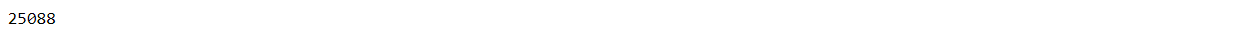

Launch the function to create the comparison table :

In [27]:
import timeit
import datetime

# start measuring
start_time = timeit.default_timer()

# execute code
df_output = data_describe()

# stop measuring
elapsed = timeit.default_timer() - start_time

# converting secs in hrs:min:sec
convert = str(datetime.timedelta(seconds = elapsed))

1/1 [==============================] - 6s 6s/step=============>   (15 + 1) / 16]


ValueError: Cannot convert column into bool: please use '&' for 'and', '|' for 'or', '~' for 'not' when building DataFrame boolean expressions.

Exception ignored in: 'pandas._libs.lib.is_interval'
Traceback (most recent call last):
  File "/home/admin/miniconda3/lib/python3.9/site-packages/pyspark/sql/column.py", line 1044, in __nonzero__
    raise ValueError(
ValueError: Cannot convert column into bool: please use '&' for 'and', '|' for 'or', '~' for 'not' when building DataFrame boolean expressions.


ValueError: Cannot convert column into bool: please use '&' for 'and', '|' for 'or', '~' for 'not' when building DataFrame boolean expressions.

Exception ignored in: 'pandas._libs.lib.is_interval'
Traceback (most recent call last):
  File "/home/admin/miniconda3/lib/python3.9/site-packages/pyspark/sql/column.py", line 1044, in __nonzero__
    raise ValueError(
ValueError: Cannot convert column into bool: please use '&' for 'and', '|' for 'or', '~' for 'not' when building DataFrame boolean expressions.


SUMMARY DATAFRAMES…


In [28]:
print("the above cell was executed in",convert,"(hr:min:sec)")

the above cell was executed in 11:24:17.428995 (hr:min:sec)


In [29]:
df_output.describe()

,Nb_Features
count,420.0
mean,25088.0
std,0.0
min,25088.0
25%,25088.0
50%,25088.0
75%,25088.0
max,25088.0


In [33]:
print(f"We can check in the table that both mean, min and max values are identical : \
{df_output.Nb_Features.mean():_.0f} for the field Nb_Features.")

We can check in the table that both mean, min and max values are identical : 25_088 for the field Nb_Features.


We will compare this table later on with the one we will create from the S3 saved output files to make sure that data were loaded properly.

# 7. Save features outputs in S3 in 3 separate folders under one umbrella

For the sake of the example we performed a data picking of 3 differents fruits and vegetables from the 3 root folders.
The output features will be saved in separate folders to respect the same organisation.

-  images1 : Features_Output/Test/apple_6/

-  images2 : Features_Output/Training/apple_red_1/

-  images3 : Features_Output/Validation/apple_hit_1/

In [30]:
%%time
features_df1.withColumn("features", col("features").cast("string"))\
.write.mode('overwrite')\
.option("header",True)\
.csv("s3a://s3-ds-p8/Features_Output/Test/apple_6/")

22/11/17 19:26:14 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


22/11/17 19:26:22 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.
22/11/17 19:26:22 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 18s 18s/step


22/11/17 19:26:46 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.
22/11/17 19:26:46 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 18s 18s/step


22/11/17 19:27:09 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


22/11/17 19:27:11 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 17s 17s/step


22/11/17 19:27:31 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 17s 17s/step                (5 + 2) / 16]


22/11/17 19:27:38 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 13s 13s/step


22/11/17 19:27:49 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 14s 14s/step


22/11/17 19:28:00 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 14s 14s/step


22/11/17 19:28:10 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 14s 14s/step


22/11/17 19:28:22 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 15s 15s/step


22/11/17 19:28:33 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 16s 16s/step


22/11/17 19:28:46 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 16s 16s/step


22/11/17 19:28:56 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 16s 16s/step


22/11/17 19:29:08 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 11s 11s/step===========>   (15 + 1) / 16]


CPU times: user 194 ms, sys: 12.2 ms, total: 206 ms
Wall time: 3min 22s


In [31]:
%%time
features_df2.withColumn("features", col("features").cast("string"))\
.write.mode('overwrite')\
.option("header",True)\
.csv("s3a://s3-ds-p8/Features_Output/Training/carrot_1/")

22/11/17 19:29:36 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


22/11/17 19:29:41 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.
22/11/17 19:29:41 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 12s 12s/step


22/11/17 19:29:57 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


22/11/17 19:29:58 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 8s 8s/step


22/11/17 19:30:11 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


22/11/17 19:30:12 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 3s 3s/step


22/11/17 19:30:17 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


22/11/17 19:30:17 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 3s 3s/step


22/11/17 19:30:22 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.
22/11/17 19:30:23 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 3s 3s/step


22/11/17 19:30:27 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


22/11/17 19:30:28 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 3s 3s/step


22/11/17 19:30:33 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


22/11/17 19:30:33 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 3s 3s/step


22/11/17 19:30:39 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


22/11/17 19:30:39 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 3s 3s/step


CPU times: user 106 ms, sys: 2.91 ms, total: 109 ms
Wall time: 1min 18s


In [32]:
%%time
features_df3.withColumn("features", col("features").cast("string"))\
.write.mode('overwrite')\
.option("header",True)\
.csv("s3a://s3-ds-p8/Features_Output/Validation/pear_1/")

22/11/17 19:30:55 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


22/11/17 19:31:02 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.
22/11/17 19:31:02 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 6s 6s/step


22/11/17 19:31:09 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


22/11/17 19:31:10 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 5s 5s/step


22/11/17 19:31:16 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


22/11/17 19:31:17 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 5s 5s/step


22/11/17 19:31:23 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


22/11/17 19:31:24 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 5s 5s/step


22/11/17 19:31:31 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


22/11/17 19:31:31 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 6s 6s/step


22/11/17 19:31:39 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.
22/11/17 19:31:40 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 13s 13s/step


22/11/17 19:31:55 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 15s 15s/step               (11 + 2) / 16]


22/11/17 19:31:59 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 16s 16s/step


22/11/17 19:32:17 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 16s 16s/step


22/11/17 19:32:22 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 16s 16s/step===========>   (15 + 1) / 16]


CPU times: user 96.9 ms, sys: 5.48 ms, total: 102 ms
Wall time: 1min 59s


We can check that output files were correctly saved on S3 :

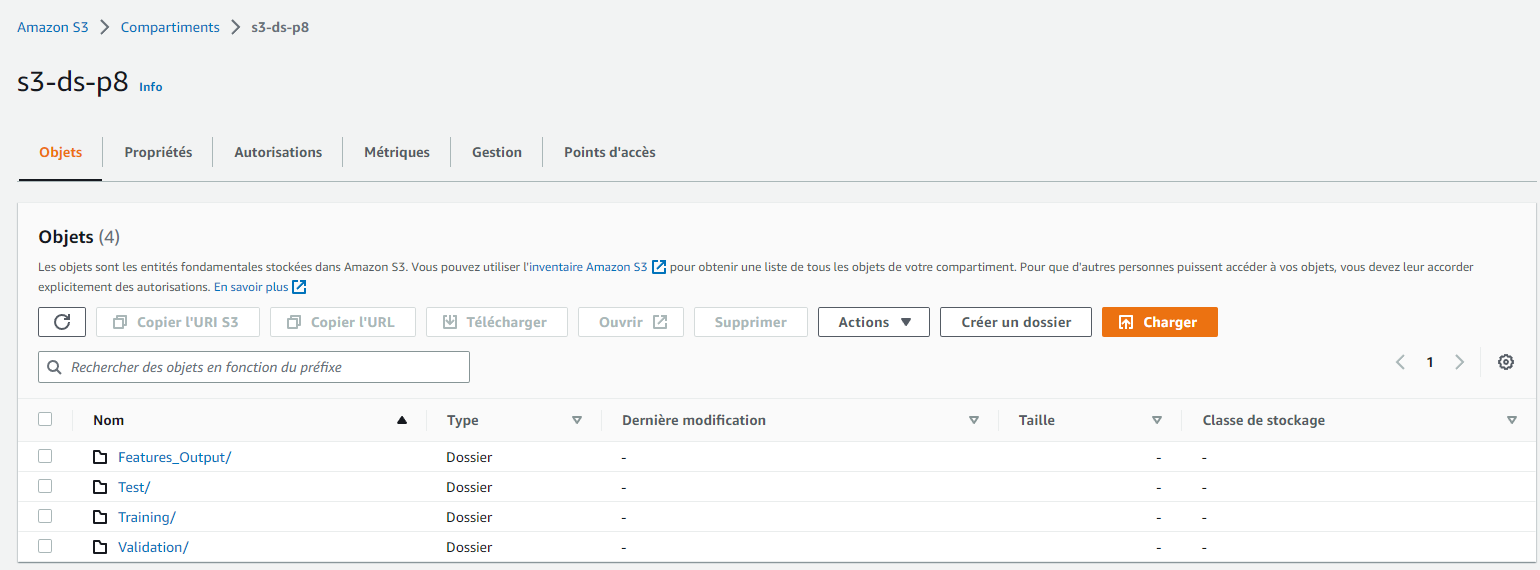

**Test / apple_6** :

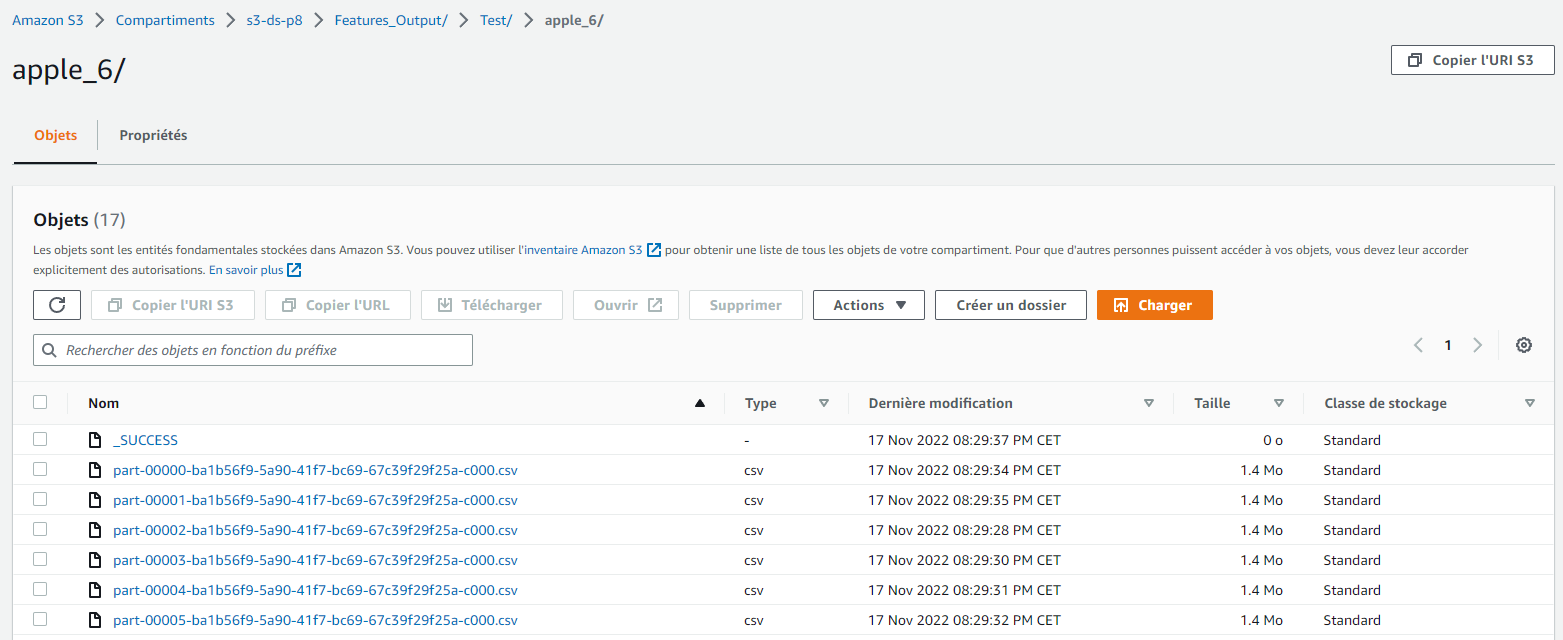

**Training / carrot_1** :

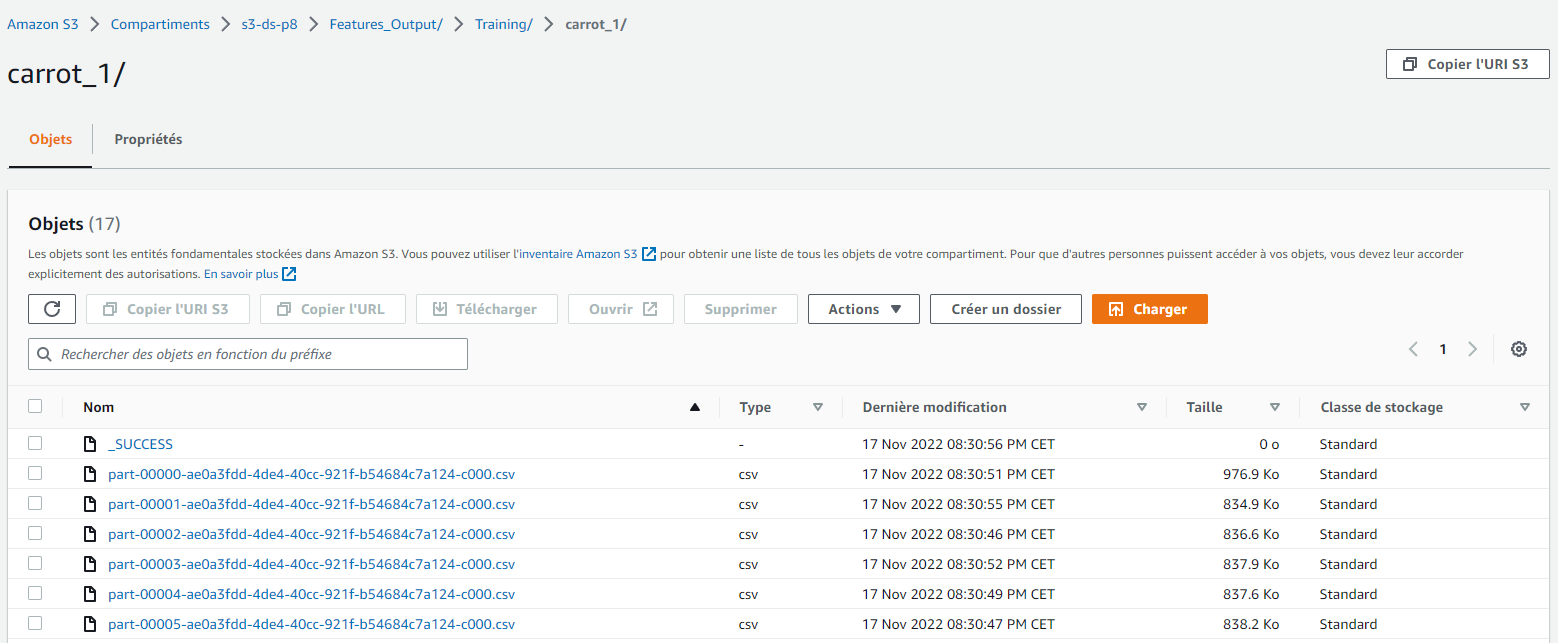

**Validation / pear_1** :

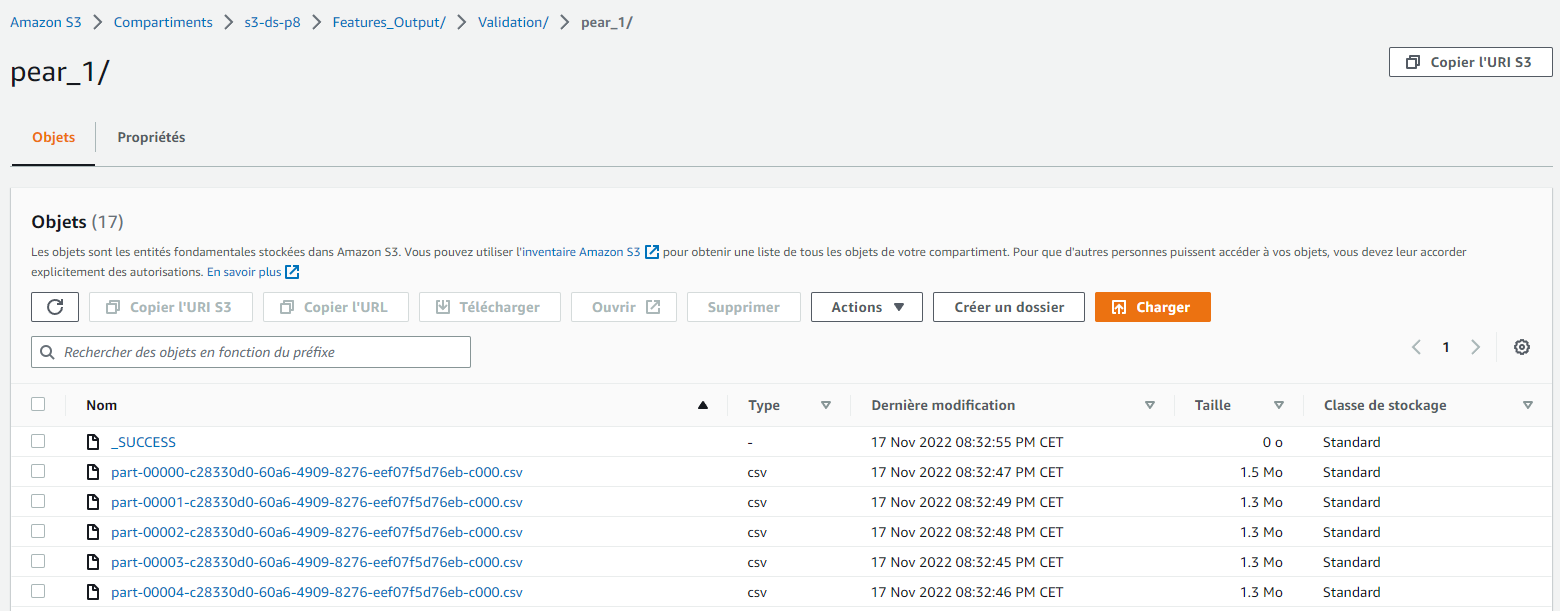

# 8. Check that files loaded on S3 have the same number of features than the original dataframes 

Next step is to check whether or not the operation of converting Spark dataframes into csv went well, and whether the files were correctly loaded to S3 in their respective folders.

Here below I printed an extract of the local notebook used to build the exact **same summary table** based on the **48 csv files that were previously **loaded at step 7**. These files gathered **data from 420 images** used for the test. 

For each file, **applying VGG16 model created 25088 features**.

As we can see in the summary table below, on S3 I found the **exact number of original image files (420), divided into 48 csv files**, with the **same number of features (25088)**.

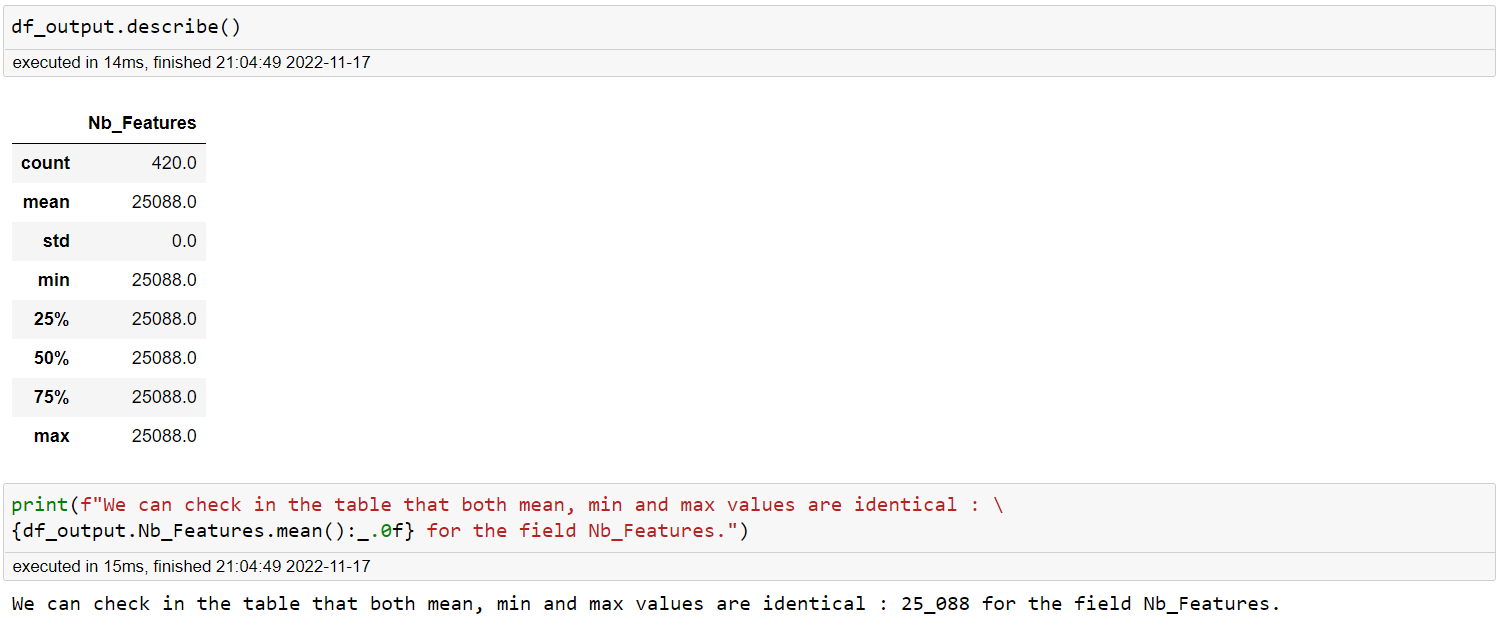